# Data Loading and Preprocessing 
---

This notebook will handle the preprocessing of the data that will be used in the master thesis.

**Contents:**
1. [Extracting the data from the Cognite API](#data-extraction)
2. [Handling missing data (NA)](#na-handling)
3. [Handling outliers/anomalies](#outlier-handling)
4. [Data partitioning](#data-partitioning)
5. [Data scaling by standardisation](#data-scaling)
6. [Feature selection](#feature-selection)
7. [Exporting the data](#saving)

In [1]:
# import external modules
import sys, os

ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH + "src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

from matplotlib import rc 
from datetime import datetime

import functions as f

from cognite.client import CogniteClient

SEED=100
np.random.seed(SEED)

In [2]:
# set plot settings
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})
c, palette = f.color_palette()
sns.set_palette(palette)

rc('figure', figsize=(12,6), dpi=200)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('axes', labelsize=14, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')
rc('text', color="#000000")
rc('xtick', color="#000000")
rc('ytick', color="#000000")

Authenticate session with the Cognite SDK using the CogniteClient with the retrieved API key, stored as an environment variable. 

In [3]:
client = CogniteClient(api_key=os.environ['COGNITE_API_SECRET'])

---
## Set notebook parameters <a class="anchor" id="notebook-parameters"></a>

In [4]:
START = datetime(2017,12, 24)  ## the start date of the asset time series interval
END = datetime(2018, 2, 24)    ## the end date of the asset time series interval 
TIME_INTERVAL_MINUTES = 1      ## the minutes between each reading in the time series
GRANULARITY = str(TIME_INTERVAL_MINUTES) + 'm' ## the string representation of TIME_INTERVAL_MINUTES
AGGREGATES = ['average']       ## the aggregates to extract from the Cognite API

NA_THRESHOLD = 2.5             ## the threshold percentage which filters relevant assets

TRAIN_PERCENTAGE = 0.6         ## percentage of observations to include in the training set
VALID_PERCENTAGE = 0.2         ## percentage of observations to include in the validation set
TEST_PERCENTAGE = 1.0 - TRAIN_PERCENTAGE - VALID_PERCENTAGE

path = ROOT_PATH + "data/metadata/tags/"
ALL_PREDICTOR_TAGS = pd.read_csv(path + "all_predictor_tags.csv", sep=";")["Name"].values
ALL_TARGET_TAGS = pd.read_csv(path + "target_tags.csv", sep=";")["Name"].values
ALL_TAGS = np.append(ALL_TARGET_TAGS, ALL_PREDICTOR_TAGS)

---
# (1) Extracting assets and time series from the Cognite API 
<a class="anchor" id="data-extraction"></a>

We use the Python SDK from Cognite to extract time series about the assets. We extract data from all 320 available tags, which are defined in `data/metadata/tags_*`. 

---

In [5]:
def read_data(tags, start=START, end=END, granularity=GRANULARITY, aggregates=AGGREGATES, timestamps=None):
    """
    Extract time series from the Cognite API given a list of tags.
    
    Args: 
        tags ([String]): A list of tags to extract time series of.
        start (datetime): A datetime object specifying the start of the interval
        end (datetime): A datetime object specifying the end of the interval
        granularity (String): Time between two samplings
        aggregates ([String]): Data properties to extract
    
    Returns: 
        pd.DataFrame: The dataframe of tags data
    """
    
    # if no predefined timestamps array
    if timestamps is None: 
        data = client.datapoints.get_datapoints_frame(list(tags), 
                                                  start=start, 
                                                  end=end, 
                                                  granularity=granularity, 
                                                  aggregates=aggregates)
    
        columns = [name.split("|")[0] for name in data.columns]
        data.columns=columns
        return data
        
    else: 
        # Cognite API is limited to extracting 100 tags at a time, so extract partly with intervals
        data_ts = pd.DataFrame(timestamps, columns=["timestamp"])
        intervals = np.arange(0,len(tags),100)
        if intervals[-1] != len(tags):
            intervals = np.append(intervals, len(tags))
            
        for i, j in enumerate(intervals[1:]):
            from_int = intervals[i]
            to_int = j

            tmp_tags = list(tags[from_int:to_int])
            tmp_data = read_data(tmp_tags)      

            data_ts = data_ts.join(tmp_data.set_index("timestamp"), on="timestamp")
            print("✓ Completed tags {0} to {1}".format(from_int, to_int))
        
        return data_ts

In [6]:
# Read targets data
print("Retrieving targets data ...")
data_targets = read_data(tags=ALL_TARGET_TAGS, timestamps=None)
print("✓ 100% completed\n*---------------------------*")
print("Number of observations:", len(data_targets))
print("Number of targets:     ", data_targets.shape[1]-1)


# Read predictors data
print("\nRetrieving predictors data...")
data_predictors = read_data(tags=ALL_PREDICTOR_TAGS, timestamps=data_targets.timestamp)
print("✓ 100% completed\n*---------------------------*")
print("Number of observations:", len(data_predictors))
print("Number of predictors:  ", data_predictors.shape[1]-1)


# Some tests to ensure consistency 
assert len(data_targets) == len(data_predictors)
assert ALL_TARGET_TAGS[0] == data_targets.columns[1] and ALL_TARGET_TAGS[-1] == data_targets.columns[-1]
assert ALL_PREDICTOR_TAGS[0] == data_predictors.columns[1] and ALL_PREDICTOR_TAGS[-1] == data_predictors.columns[-1]
assert data_predictors.shape[1] == len(ALL_PREDICTOR_TAGS)+1
assert len(np.unique(data_predictors.columns)) == len(data_predictors.columns)
assert np.all(data_targets.timestamp == data_predictors.timestamp)


# Combine datasets and make timestamp as index
DTIMESTAMPS = pd.to_datetime(data_targets.timestamp, unit="ms")
data_targets.index = DTIMESTAMPS
data_targets = data_targets.drop(columns=["timestamp"])
data_predictors.index = DTIMESTAMPS
data_predictors = data_predictors.drop(columns=["timestamp"])
data_full = pd.concat([data_targets, data_predictors], axis=1)

print(data_targets.shape, data_predictors.shape, data_full.shape)

assert np.all(data_full.index == data_targets.index)
assert len(data_full) == len(data_targets)
assert data_full.shape[-1] == data_targets.shape[-1] + data_predictors.shape[-1]
assert np.all(data_full.columns[:len(data_targets.columns)] == data_targets.columns)


Retrieving targets data ...
✓ 100% completed
*---------------------------*
Number of observations: 88685
Number of targets:      3

Retrieving predictors data...
✓ Completed tags 0 to 100
✓ Completed tags 100 to 146
✓ 100% completed
*---------------------------*
Number of observations: 88685
Number of predictors:   146
(88685, 3) (88685, 146) (88685, 149)


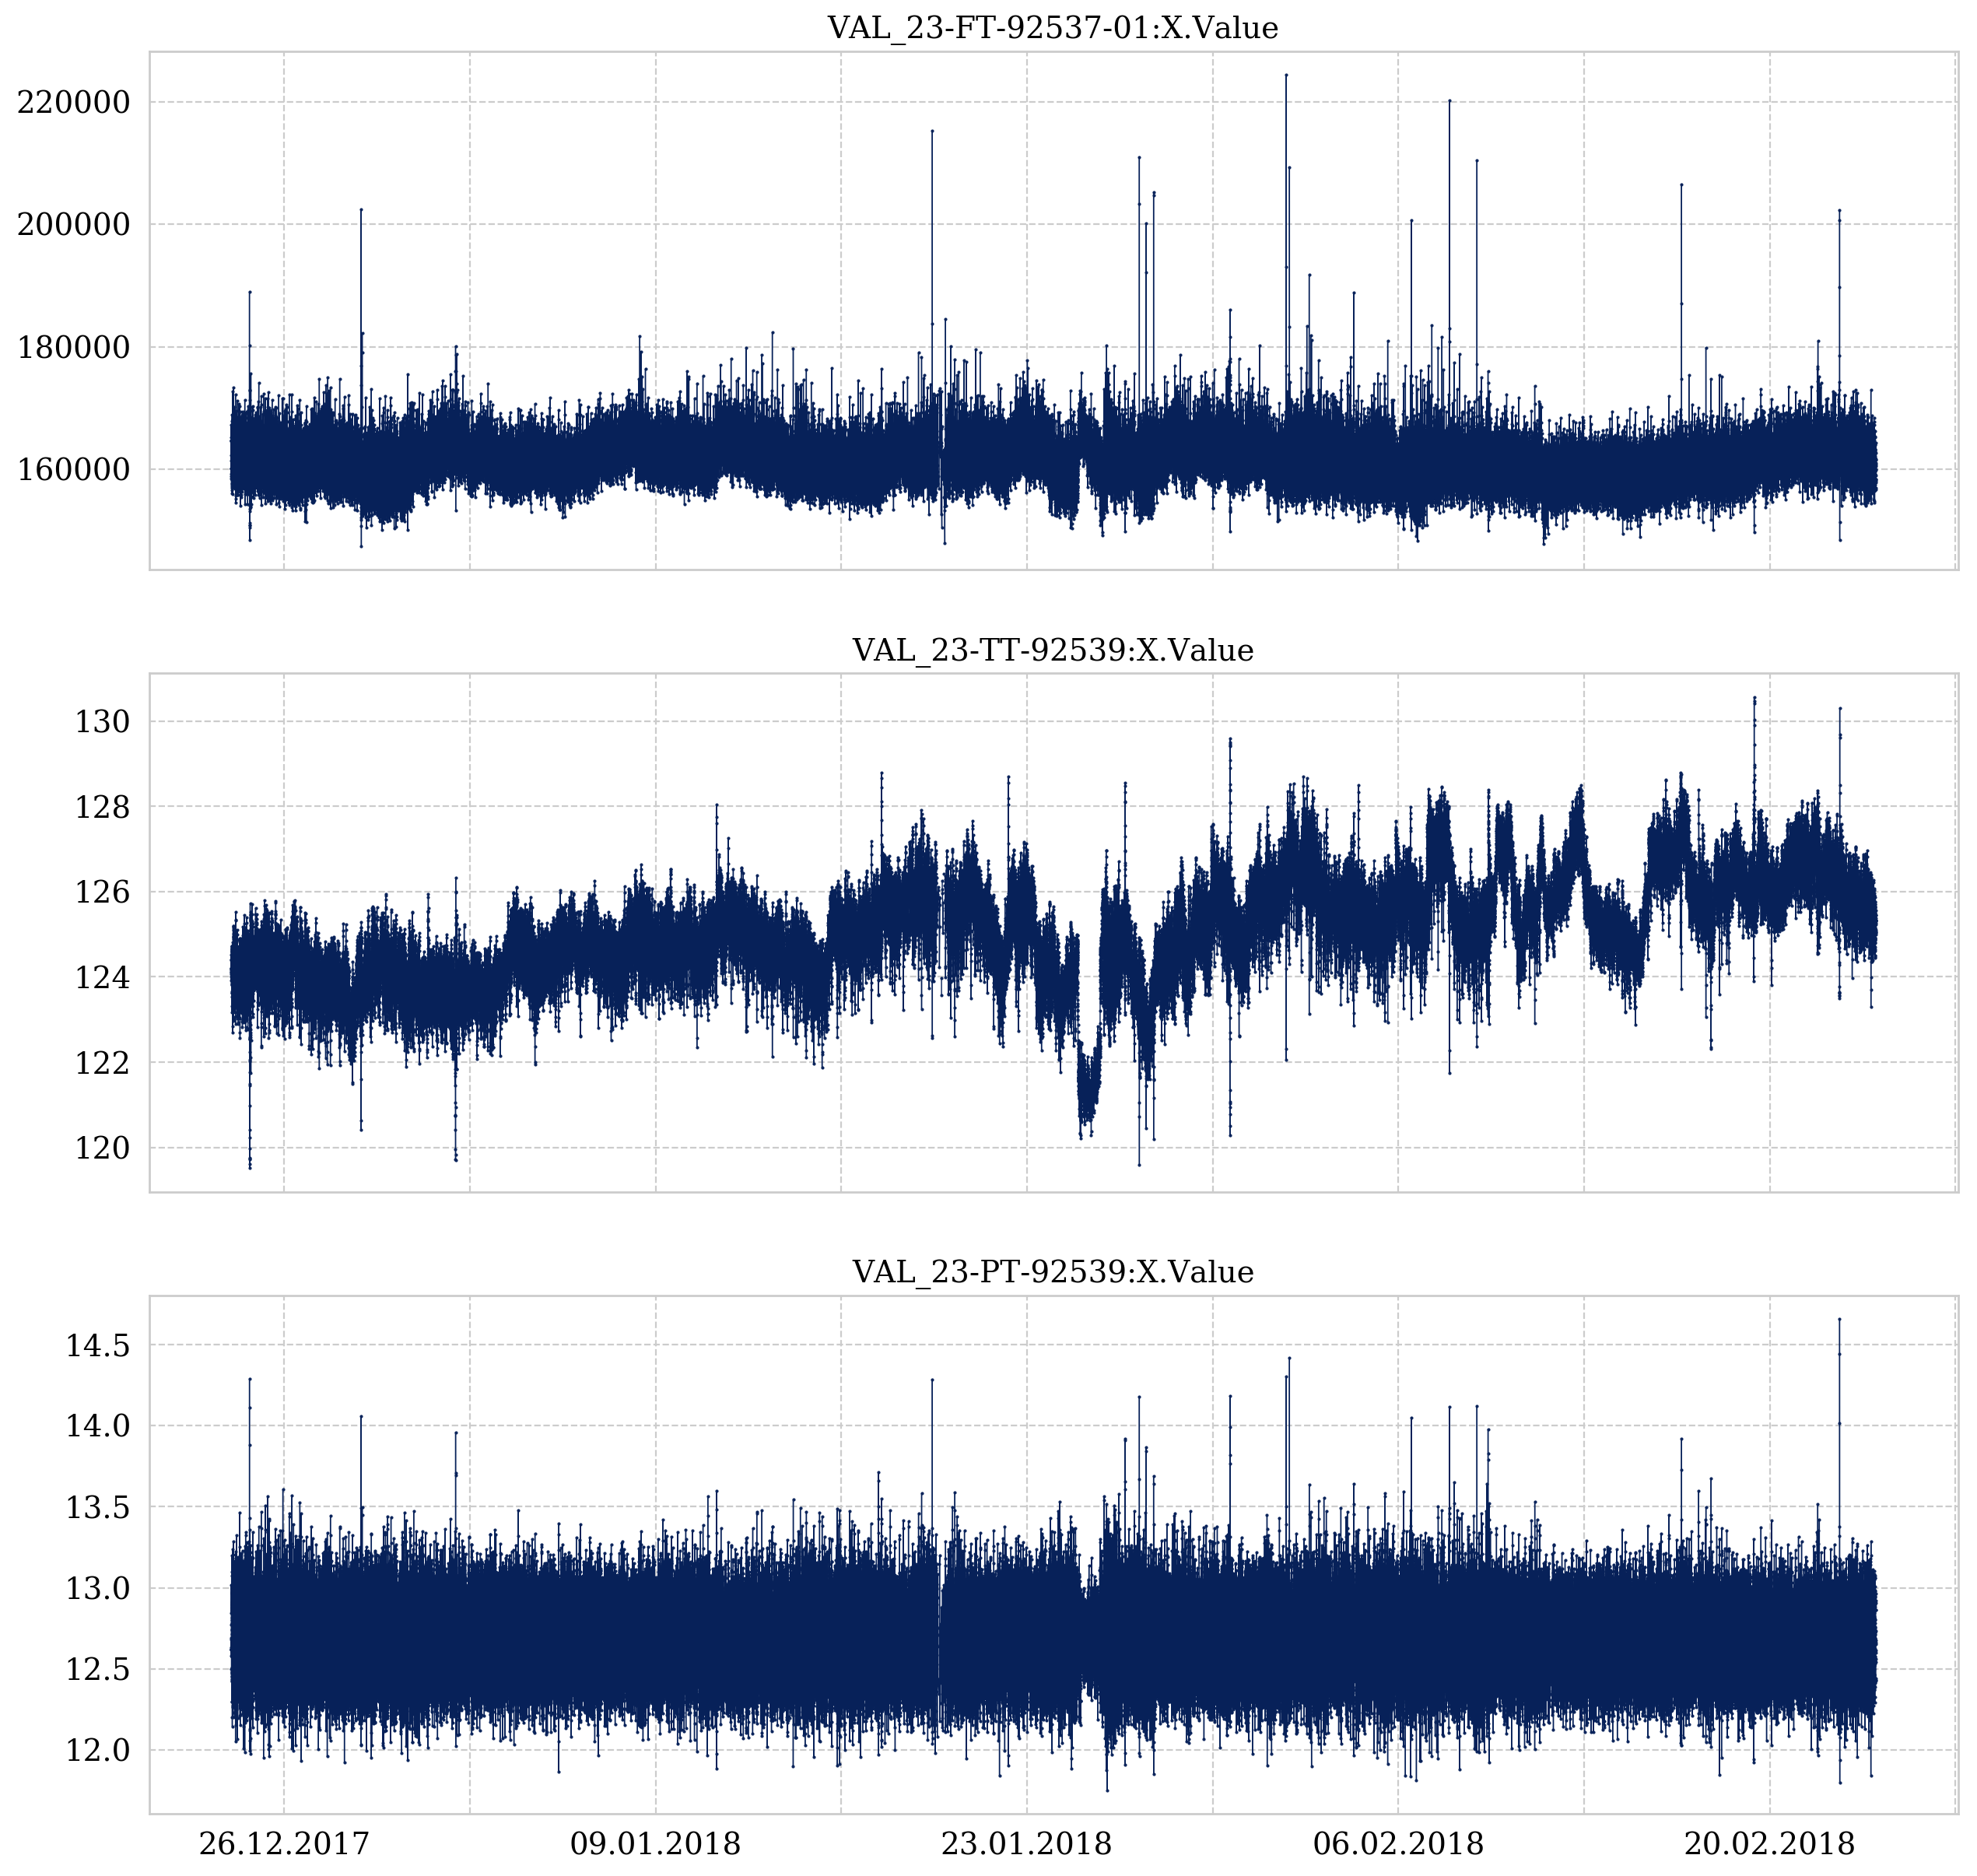

In [7]:
# plot targets
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (15,15))
for i, tag in enumerate(data_targets.columns):
    ax = axs[i]
    
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
    [label.set_visible(False) for label in ax.get_xticklabels()[1::2]]
    
    ax.plot(data_targets.index, data_targets[tag], markersize=0.5, marker="o", lw=0.5)
    ax.set_title(tag)

fig.show()

---

# (2) Handling NA values and missing data
<a class="anchor" id="na-handling"></a>

The data contains missing data. The NA values must be removed from each column before the data can be used. First, an analysis of the NA data is done. Thereafter, the NA values are handled in the following ways: 
- The assets with relative high sparsity are simply removed from the dataset. We specify a threshold of $\tau=2.5\%$ and remove any features that exceed this threshold. 
- For each NA observation, if there exists a value before and after it, its value is set to the average of the preceding and the next value. 
- For the remaining NA data, the _Amelia_ algorithm is used to impute the values. 

---

/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


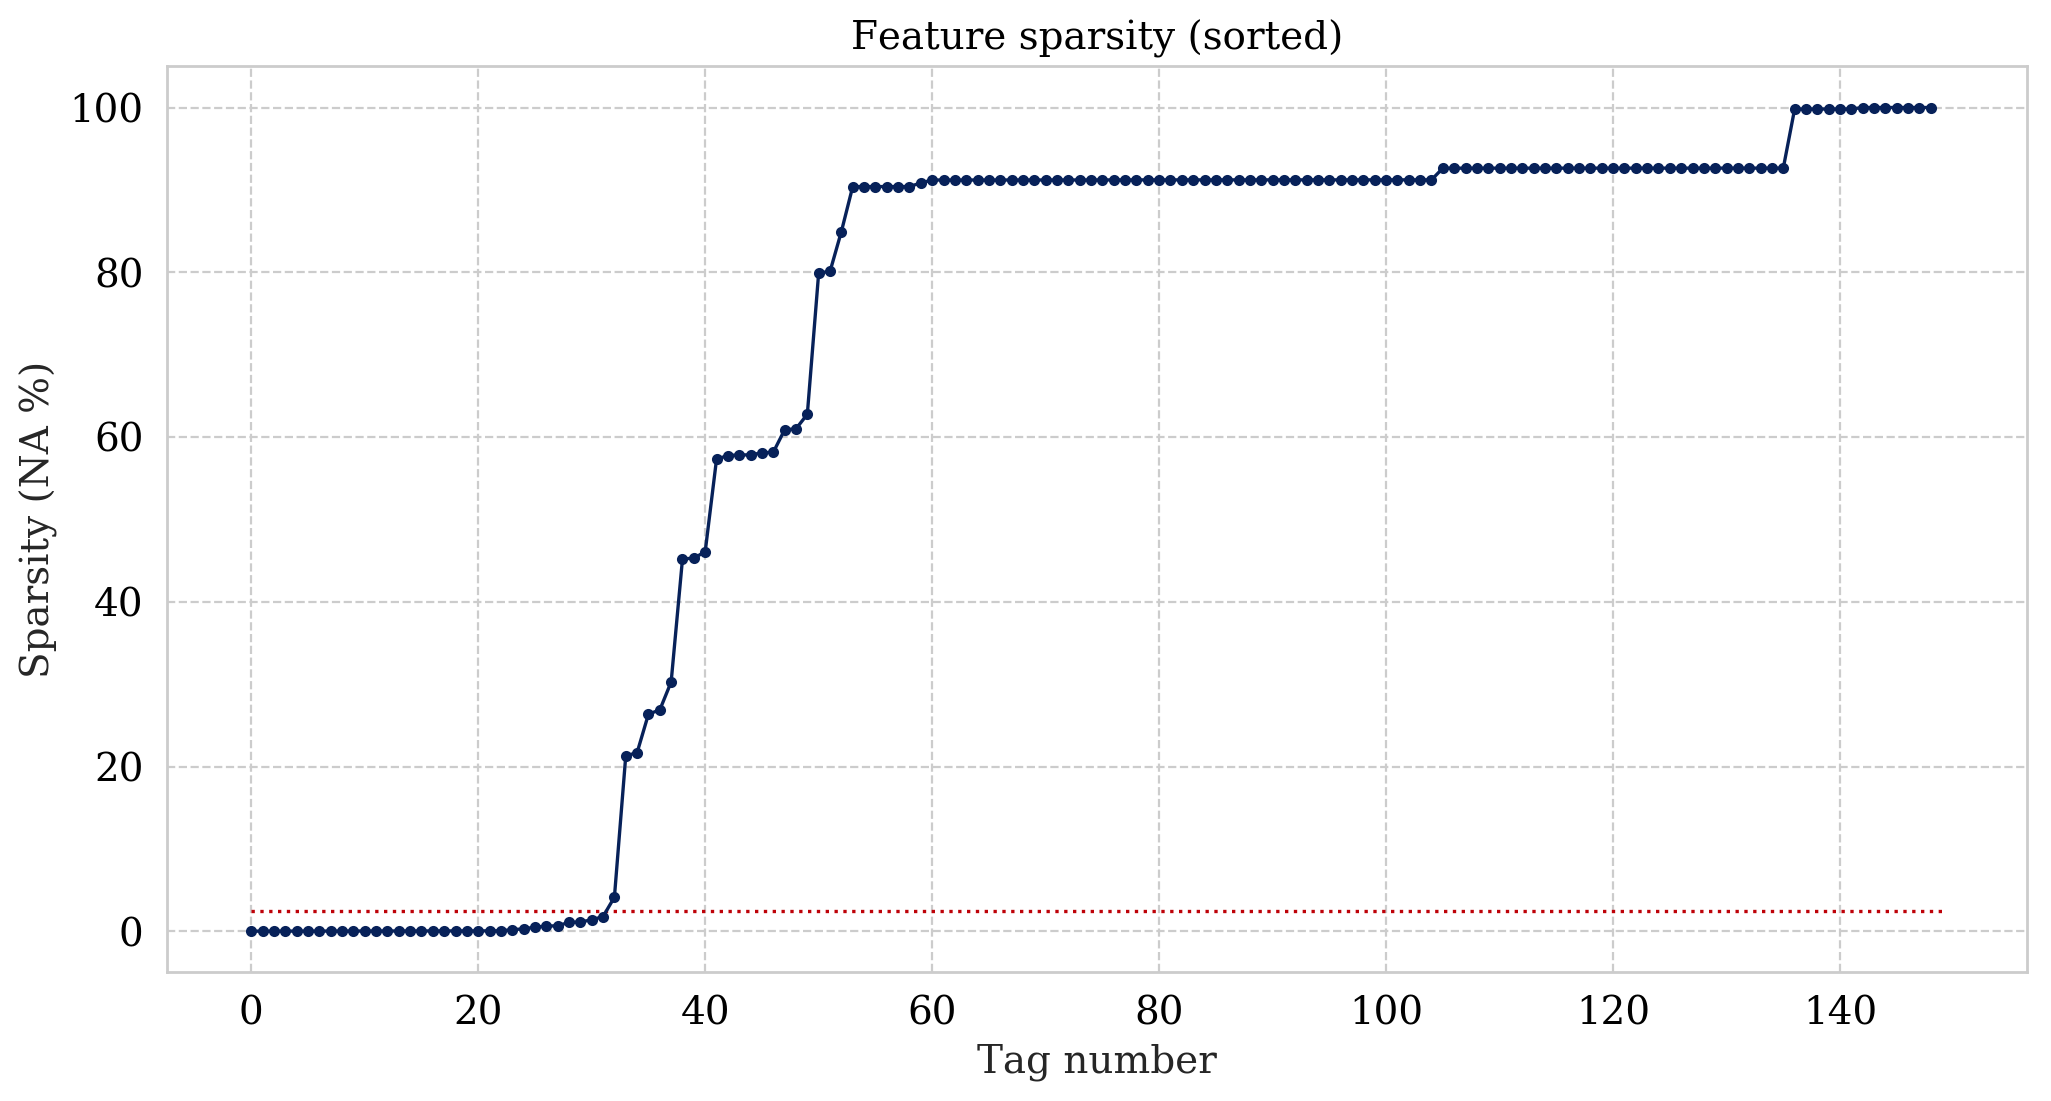

In [9]:
stats = f.get_stats_properties(data=data_full)

# plot the NAs per tag
plt.figure()
plt.plot(100*stats.sort_values(by="NAs")["NAs"].values/len(data_full), ms=3, marker="o", ls="-")
plt.title("Feature sparsity (sorted)")
plt.hlines(y=NA_THRESHOLD, xmin=0, xmax=len(data_full.columns), color=c["red"], linestyle="dotted")
plt.xlabel("Tag number")
plt.ylabel("Sparsity (NA %)")
plt.show()

**Removing high-sparsity features**

We see that most of the tags have a high sparsity, meaning that they have a high percentage of NAs in their measurements. We remove the high-sparsity tags by setting a threshold. According to the plot, this is approximately at tag 30-35. The "NA threshold percentage" decides the maximum allowed sparsity of a feature. 

In [11]:
# choose tags to keep
data_na=data_full.loc[:,stats["NAs"] <= len(data_full)*NA_THRESHOLD/100]

# make sure that the target tags are still included
assert np.all(data_na.columns[:3] == list(data_targets.columns))
assert np.all(data_na.isna().sum().values <= len(data_full)*NA_THRESHOLD/100)

# print the stats columns
print("Number of tags after filtering:", data_na.shape[-1])
print("Average sparsity (NA %): {0}%".format(round(100*np.average(data_na.isna().sum().values/len(data_na)),3)))
f.get_stats_properties(data=data_na).head(5)

Number of tags after filtering: 32
Average sparsity (NA %): 0.261%


Mean         Median          Std  \
VAL_23-FT-92537-01:X.Value  161417.157637  161285.910090  3451.291254   
VAL_23-TT-92539:X.Value        125.079347     125.064337     1.183979   
VAL_23-PT-92539:X.Value         12.698143      12.702663     0.245375   
VAL_23-FT-92512:X.Value      98389.341569   99720.986688  8799.717285   
VAL_23-FT-92521:X.Value          3.808260       4.045708     0.860034   

                                      Max            Min        1st Qu.  \
VAL_23-FT-92537-01:X.Value  224396.129479  147442.173910  159105.709228   
VAL_23-TT-92539:X.Value        130.570725     119.512739     124.280447   
VAL_23-PT-92539:X.Value         14.656747      11.752882      12.518977   
VAL_23-FT-92512:X.Value     216656.494867   36485.961863   93326.246345   
VAL_23-FT-92521:X.Value         10.354373       0.003534       3.650619   

                                  3rd Qu.     NAs  
VAL_23-FT-92537-01:X.Value  163550.644406    18.0  
VAL_23-TT-92539:X.Value        125.882580  1227.0  
VAL_23-PT-92539:X.Value         12.875018    21.0  
VAL_23-FT-92512:X.Value     104479.604258    22.0  
VAL_23-FT-92521:X.Value          4.302571  1588.0

In [12]:
print("Filtered tags based on sparsity:", len(data_na.columns))
tmp=[print(name) for name in data_na.columns]

Filtered tags based on sparsity: 32
VAL_23-FT-92537-01:X.Value
VAL_23-TT-92539:X.Value
VAL_23-PT-92539:X.Value
VAL_23-FT-92512:X.Value
VAL_23-FT-92521:X.Value
VAL_23-KA-9101-M01-62B:X.Value
VAL_23-KA-9101_ASP:VALUE
VAL_23-KA-9101_ESP:VALUE
VAL_23-LIC-92521:Z.X.Value
VAL_23-LIC-92521:Z.Y.Value
VAL_23-LT-92523:Z.X1.Value
VAL_23-LT-92523:Z.X2.Value
VAL_23-PDT-92502:X.Value
VAL_23-PDT-92522:X.Value
VAL_23-PDT-92530:X.Value
VAL_23-PDT-92534:X.Value
VAL_23-PT-92504:X.Value
VAL_23-PT-92512:X.Value
VAL_23-PT-92521:X.Value
VAL_23-PT-92523:X.Value
VAL_23-PT-92532:X.Value
VAL_23-PT-92535:X.Value
VAL_23-TIC-92504:Z.X.Value
VAL_23-TT-92502:X.Value
VAL_23-TT-92512:X.Value
VAL_23-TT-92533:X.Value
VAL_23-VA-9110-M01-EL:XS.MeasuredValues.CurrentL2.Value.Value
VAL_23_FIC_92543_01:Z.X.Value
VAL_23_KA_9101_M01_62C:Z.X.Value
VAL_23_PT_92531:Z.X.Value
VAL_23_TT_92532:Z.X.Value
VAL_23_ZT_92543:Z.X.Value


### Handling missing data

In order to handle the missing data, we do the following: 
- When the preceding and succeeding values exist, the missing value is imputed linearly (the average of the preceding and the succeeding values).
- The remaining NA values are imputed by the Amelia algorithm

**Linear imputation**

In [14]:
## If the value exists before and after, then impute it linearly
data_imp = data_na.copy()

for col in range(data_imp.shape[-1]):
    idxs = np.where(data_imp.iloc[:,col].isna())[0]
    for idx in idxs: 
        
        # if the index is the first or last, continue
        if idx == 0 or idx == len(data_na):
            continue
        
        curr_val = data_imp.iloc[idx, col]
        next_val = data_imp.iloc[idx+1, col]
        last_val = data_imp.iloc[idx-1, col]
        
        # if value is 
        if np.isnan(curr_val) and not np.isnan(last_val) and not np.isnan(next_val):
            data_imp.iloc[idx,col] = np.average([last_val, next_val])

new_percentage = round(100*np.average(data_imp.isna().sum().values/len(data_imp)),3)
old_percentage = round(100*np.average(data_na.isna().sum().values/len(data_na)),3)
print("Old sparsity: {}%, ".format(old_percentage) + 
      "New sparsity: {}%, ".format(new_percentage) + 
      "Improvement: {}%".format(round(100*(1-new_percentage/old_percentage),3)))

f.get_stats_properties(data=data_imp).head(5)

Old sparsity: 0.261%, New sparsity: 0.097%, Improvement: 62.835%


Mean         Median          Std  \
VAL_23-FT-92537-01:X.Value  161417.151479  161285.897240  3451.246477   
VAL_23-TT-92539:X.Value        125.080403     125.066368     1.183835   
VAL_23-PT-92539:X.Value         12.698141      12.702644     0.245368   
VAL_23-FT-92512:X.Value      98389.558110   99721.391043  8799.594023   
VAL_23-FT-92521:X.Value          3.798062       4.043526     0.871534   

                                      Max            Min        1st Qu.  \
VAL_23-FT-92537-01:X.Value  224396.129479  147442.173910  159105.709228   
VAL_23-TT-92539:X.Value        130.570725     119.512739     124.282265   
VAL_23-PT-92539:X.Value         14.656747      11.752882      12.518985   
VAL_23-FT-92512:X.Value     216656.494867   36485.961863   93326.384333   
VAL_23-FT-92521:X.Value         10.354373       0.003534       3.639982   

                                  3rd Qu.     NAs  
VAL_23-FT-92537-01:X.Value  163550.644406    14.0  
VAL_23-TT-92539:X.Value        125.883848   105.0  
VAL_23-PT-92539:X.Value         12.875013    12.0  
VAL_23-FT-92512:X.Value     104479.715896    17.0  
VAL_23-FT-92521:X.Value          4.301171  1142.0

**Imputing remaining NA with Amelia**

Next, we use the Amelia algorithm to impute the remaining NA values. Amelia is an R package for the multiple imputation of incomplete data. Multiple imputation is a method to overcome the computational problem of missing data while maintaining good statistical properties. Multiple imputation involves imputing m values for each missing cell in your data matrix and creating m "completed" data sets. (Across these completed data sets, the observed values are the same, but the missing values are filled in with different imputations that reflect our uncertainty about the missing data.) After imputation, Amelia will then save the m data sets.

In [15]:
%load_ext rpy2.ipython

In [16]:
%%R -i data_imp -w 5 -h 5 --units in -r 200

# install.packages(c("Amelia", "stringr"))  ## uncomment if you need to install the libraries
library(Amelia)
library(stringr)

print(sum(is.na(data_imp)))
amelia.data <- amelia(data_imp, m = 1, parallel = "multicore")

imput <- 1
am.data <- amelia.data$imputations[[imput]]
print(sum(is.na(am.data)))
percentage_na <- round(sum(is.na(am.data)) / nrow(am.data),2)
cat(str_glue('Percentage NAs: {percentage_na}%'), '\n')

# write to file
write.table(
    am.data, 
    "../../data/amelia_data.csv",
    row.names = FALSE,
    sep = ","
)

R[write to console]: Loading required package: Rcpp

R[write to console]: ## 
## Amelia II: Multiple Imputation
## (Version 1.7.5, built: 2018-05-07)
## Copyright (C) 2005-2019 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 



[1] 2753
-- Imputation 1 --

  1  2  3  4  5  6  7

[1] 0
Percentage NAs: 0% 


In [17]:
# read the data
path=ROOT_PATH+"data/amelia_data.csv"
data_amelia = pd.read_csv(path, sep=",")

data_amelia.columns = data_imp.columns
data_amelia.index = data_imp.index

# if not all columns have 0 NA, use forward filling
if not np.all(data_amelia.isna().sum() == 0):
    data_amelia = data_amelia.fillna(method="ffill")
    data_amelia = data_amelia.fillna(method="backfill")

assert np.all(data_amelia.isna().sum() == 0)

# delete the data file
os.remove(path)

---

# (3) Handling outliers 
<a class="anchor" id="outlier-handling"></a>

Outliers are ignored for the time being. 

---

# (4) Partitioning the data into training, validation and test sets



In [20]:
train_size = int(TRAIN_PERCENTAGE * len(data_amelia))
valid_size = int(VALID_PERCENTAGE * len(data_amelia))
test_size = len(data_amelia) - train_size - valid_size

data_train = data_amelia[:train_size]
data_valid = data_amelia[train_size:train_size+valid_size]
data_test = data_amelia[-test_size:]

print(data_train.shape, data_valid.shape, data_test.shape)

(53211, 32) (17737, 32) (17737, 32)


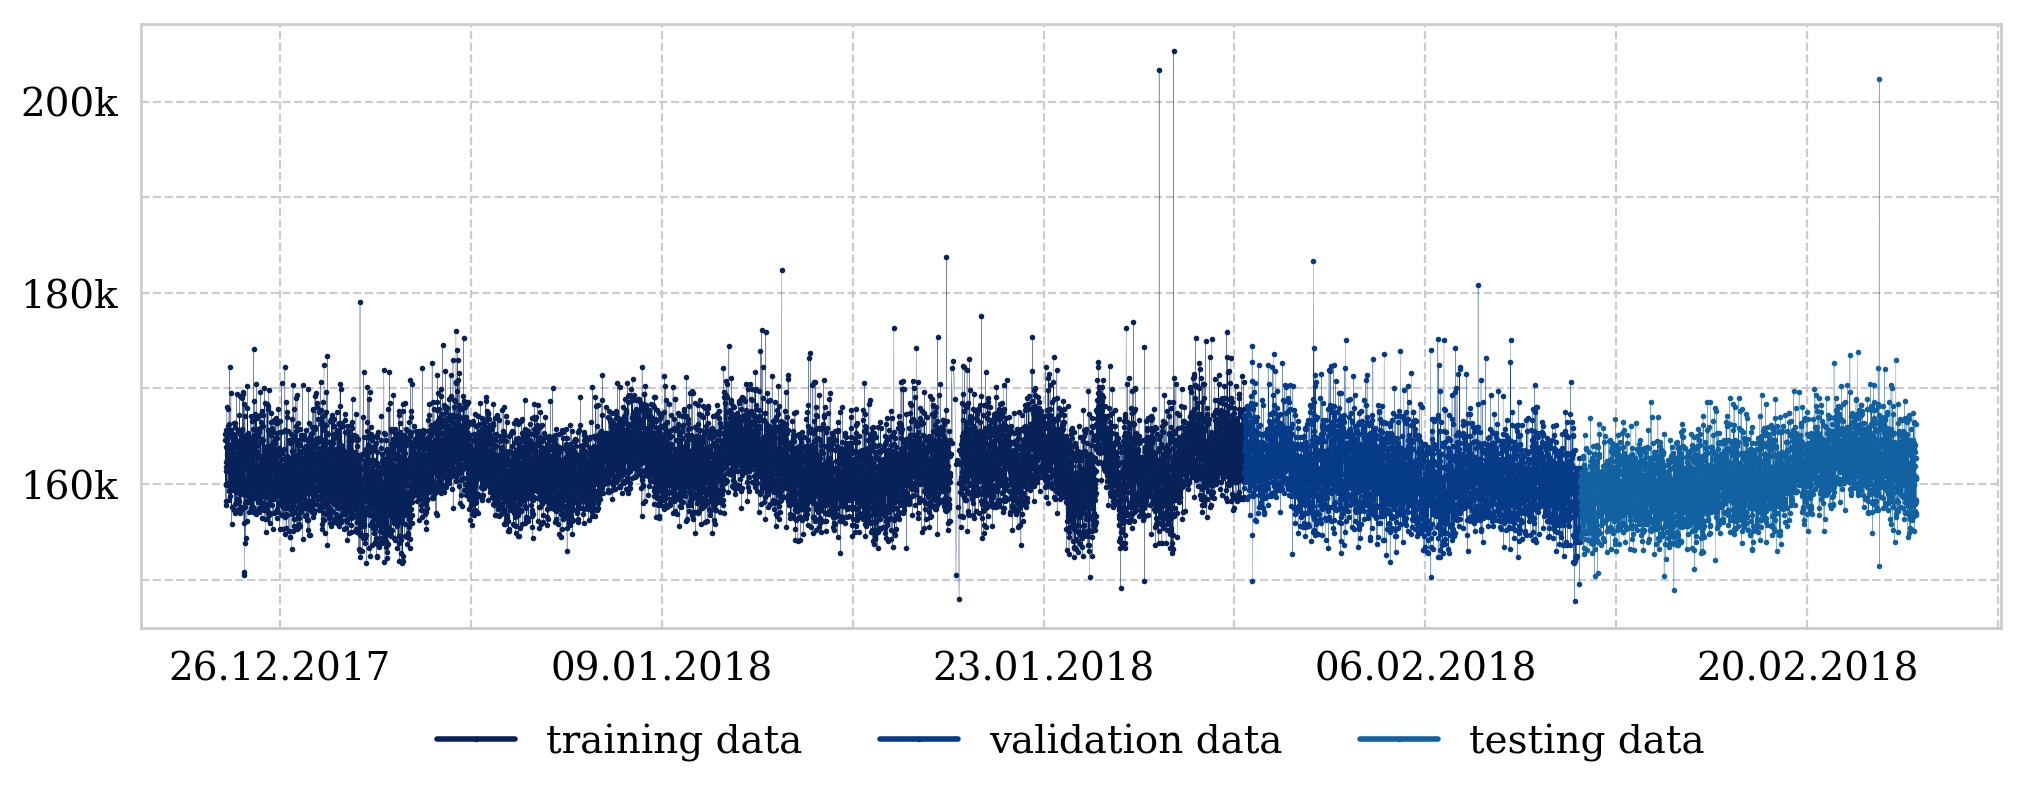

In [21]:
# plot the regions for a feature
target = 0 # the flow
delta = 5

fig,ax = plt.subplots(1,1,figsize=(12,4))

ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))

# training data
ax.plot(DTIMESTAMPS[:train_size:delta], 
         data_train.values[::delta, target], 
         marker="o", ms=1, lw = 0.1, ls="-", label="training data")

# validation data
ax.plot(DTIMESTAMPS[train_size:-test_size:delta], 
         data_valid.values[::delta, target],  
         marker="o", ms=1, lw = 0.1, ls="-", label="validation data")

# testing data
ax.plot(DTIMESTAMPS[-test_size::delta], 
         data_test.values[::delta, target],  
         marker="o", ms=1, lw = 0.1, ls="-", label="testing data")

#plt.ylabel("Discharge flow ")
leg = ax.legend(frameon=False, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.1), fancybox=True)

for line in leg.get_lines():
    line.set_linewidth(2.0)


ylabels = [str(int(i//1000)) + "k" for i in ax.get_yticks()]
ax.set_yticklabels(ylabels)
for label in ax.get_yticklabels()[1::2]:
    label.set_visible(False)

for label in ax.get_xticklabels()[1::2]:
    label.set_visible(False)
    
for label in ax.get_xticklabels()[-1:]:
    label.set_visible(False)
    
fig.show()

# (5) Data scaling
<a class="anchor" id="data-scaling"></a>

---
There are essentially two common ways to scale the data: 
1. Standardisation
    - Transforming the data to zero mean and unit variance
2. Normalisation
    - Transforming the data column-wise between 0 and 1 such that the max value is set to 1 and the minimum value to 0.

Here we'll go for option 1: Standardisation.

In addition, **data snooping** is a concern that must be considered. Important that the data is scaled according to the data in the **training set** and *not* the data included in the validation and the testing set here. In essence, everything that's learnt must be learnt from the training set, and we pretend to know nothing about the validation and testing set.  

Scaling by standardization


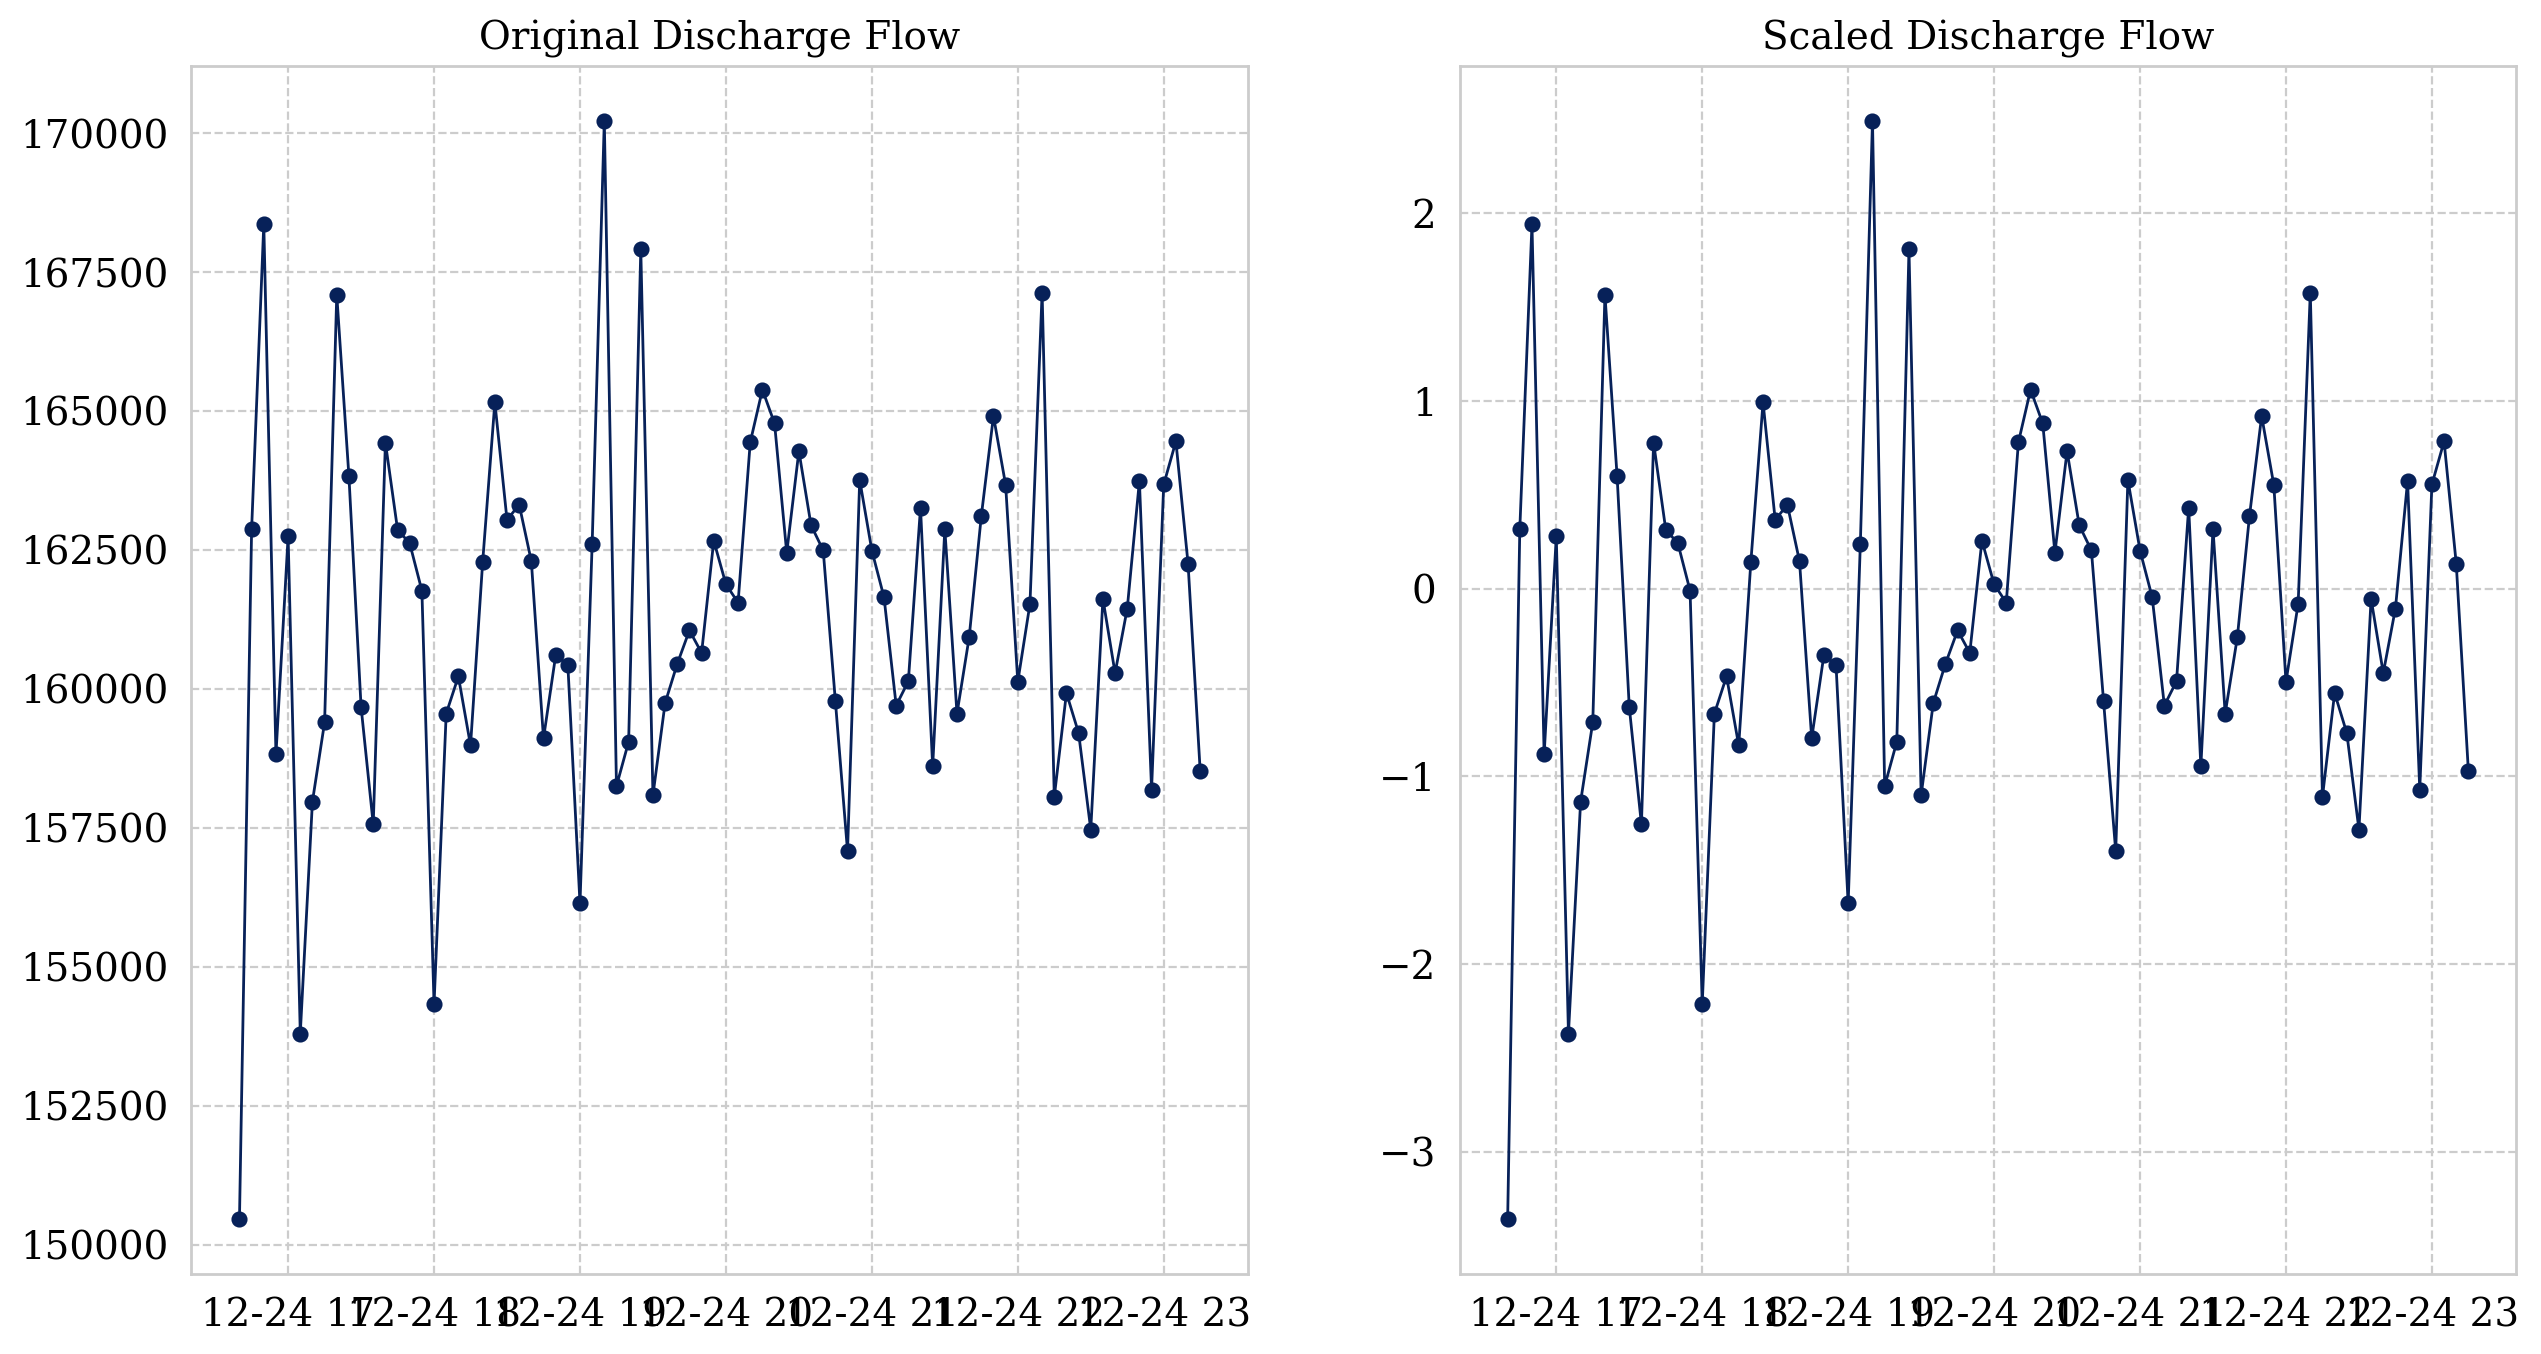

Mean    Median  Std        Max       Min  \
VAL_23-FT-92537-01:X.Value  3.949651e-13 -0.039654  1.0  15.822574 -4.253939   
VAL_23-TT-92539:X.Value     8.090250e-13  0.021671  1.0   4.406221 -5.098995   
VAL_23-PT-92539:X.Value    -2.488366e-14  0.010479  1.0   6.424514 -3.816045   
VAL_23-FT-92512:X.Value    -4.117004e-14  0.084046  1.0  13.968290 -6.663839   
VAL_23-FT-92521:X.Value     2.401943e-14  0.300585  1.0   3.620703 -4.139751   

                             1st Qu.   3rd Qu.  NAs  
VAL_23-FT-92537-01:X.Value -0.667895  0.623684  0.0  
VAL_23-TT-92539:X.Value    -0.586277  0.648887  0.0  
VAL_23-PT-92539:X.Value    -0.734594  0.720473  0.0  
VAL_23-FT-92512:X.Value    -0.539229  0.674218  0.0  
VAL_23-FT-92521:X.Value    -0.210305  0.588064  0.0

In [23]:
def plot_scale_comparison(data, data_scaled, timestamps=DTIMESTAMPS, target=0):
    """
    Function to plot the comparison between scaled and unscaled data
    """
    inds = np.arange(1000,1400,5)

    fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, figsize=(15,8))
    ax1.plot_date(timestamps[inds], data[inds,target], linewidth=1.0, linestyle="-")
    ax1.set_title("Original Discharge Flow")
    ax2.plot_date(DTIMESTAMPS[inds], data_scaled[inds,target], linewidth=1.0, linestyle="-")
    ax2.set_title("Scaled Discharge Flow")
    plt.show()

means = data_train.mean().tolist()
stds = data_train.std().tolist()

data_scaled = data_amelia.copy()
data_scaled -= means
data_scaled /= stds

data_train_scaled = data_scaled[:train_size]
data_valid_scaled = data_scaled[train_size:train_size+valid_size]
data_test_scaled = data_scaled[-test_size:]

print("Scaling by standardization")
plot_scale_comparison(data=data_amelia.values, data_scaled=data_scaled.values)

f.get_stats_properties(data_scaled[:train_size]).head()

# (6) Feature selection
<a class="anchor" id="feature-selection"></a>

---

The remaining 32 features are not all equally informative. Some are noisy and only pollute the
training process, many of them are highly correlated and contain mutually overlapping information, others are nearly constant variables across the whole dataset with approximately zero variance, while some are simply irrelevant. Feature selection is the process of selecting the most influential input features with respect to the target features. The feature selection process results in a dataset with reduced dimensionality which is beneficial for a number of reasons; the datasets are more comprehensible and easier to work with, they are less demanding computationally to process and analyze, and will most likely lead to increased performance of the
machine learning models. 

We perform the following feature selection steps: 
- If any two predictors have a Pearson correlation coefficient greater or lower than ±0.95, we selected one of them arbitrarily. 
- We apply the _Boruta_ algorithm for each of the targets, and select the predictors that are considerably more influential than the others.

#### Removing highly correlated features


Removed 11 features:

['VAL_23-KA-9101-M01-62B:X.Value', 'VAL_23-LT-92523:Z.X1.Value', 'VAL_23-PDT-92530:X.Value', 'VAL_23-PT-92504:X.Value', 'VAL_23-PT-92532:X.Value', 'VAL_23-PT-92535:X.Value', 'VAL_23_PT_92531:Z.X.Value', 'VAL_23-PT-92521:X.Value', 'VAL_23-TT-92502:X.Value', 'VAL_23-TT-92533:X.Value', 'VAL_23_FIC_92543_01:Z.X.Value']

There are 21 features remaining:

['VAL_23-FT-92537-01:X.Value', 'VAL_23-TT-92539:X.Value', 'VAL_23-PT-92539:X.Value', 'VAL_23-FT-92512:X.Value', 'VAL_23-FT-92521:X.Value', 'VAL_23-KA-9101_ASP:VALUE', 'VAL_23-KA-9101_ESP:VALUE', 'VAL_23-LIC-92521:Z.X.Value', 'VAL_23-LIC-92521:Z.Y.Value', 'VAL_23-LT-92523:Z.X2.Value', 'VAL_23-PDT-92502:X.Value', 'VAL_23-PDT-92522:X.Value', 'VAL_23-PDT-92534:X.Value', 'VAL_23-PT-92512:X.Value', 'VAL_23-PT-92523:X.Value', 'VAL_23-TIC-92504:Z.X.Value', 'VAL_23-TT-92512:X.Value', 'VAL_23-VA-9110-M01-EL:XS.MeasuredValues.CurrentL2.Value.Value', 'VAL_23_KA_9101_M01_62C:Z.X.Value', 'VAL_23_TT_92532:Z.X.Value', 'VAL_23_ZT_9254

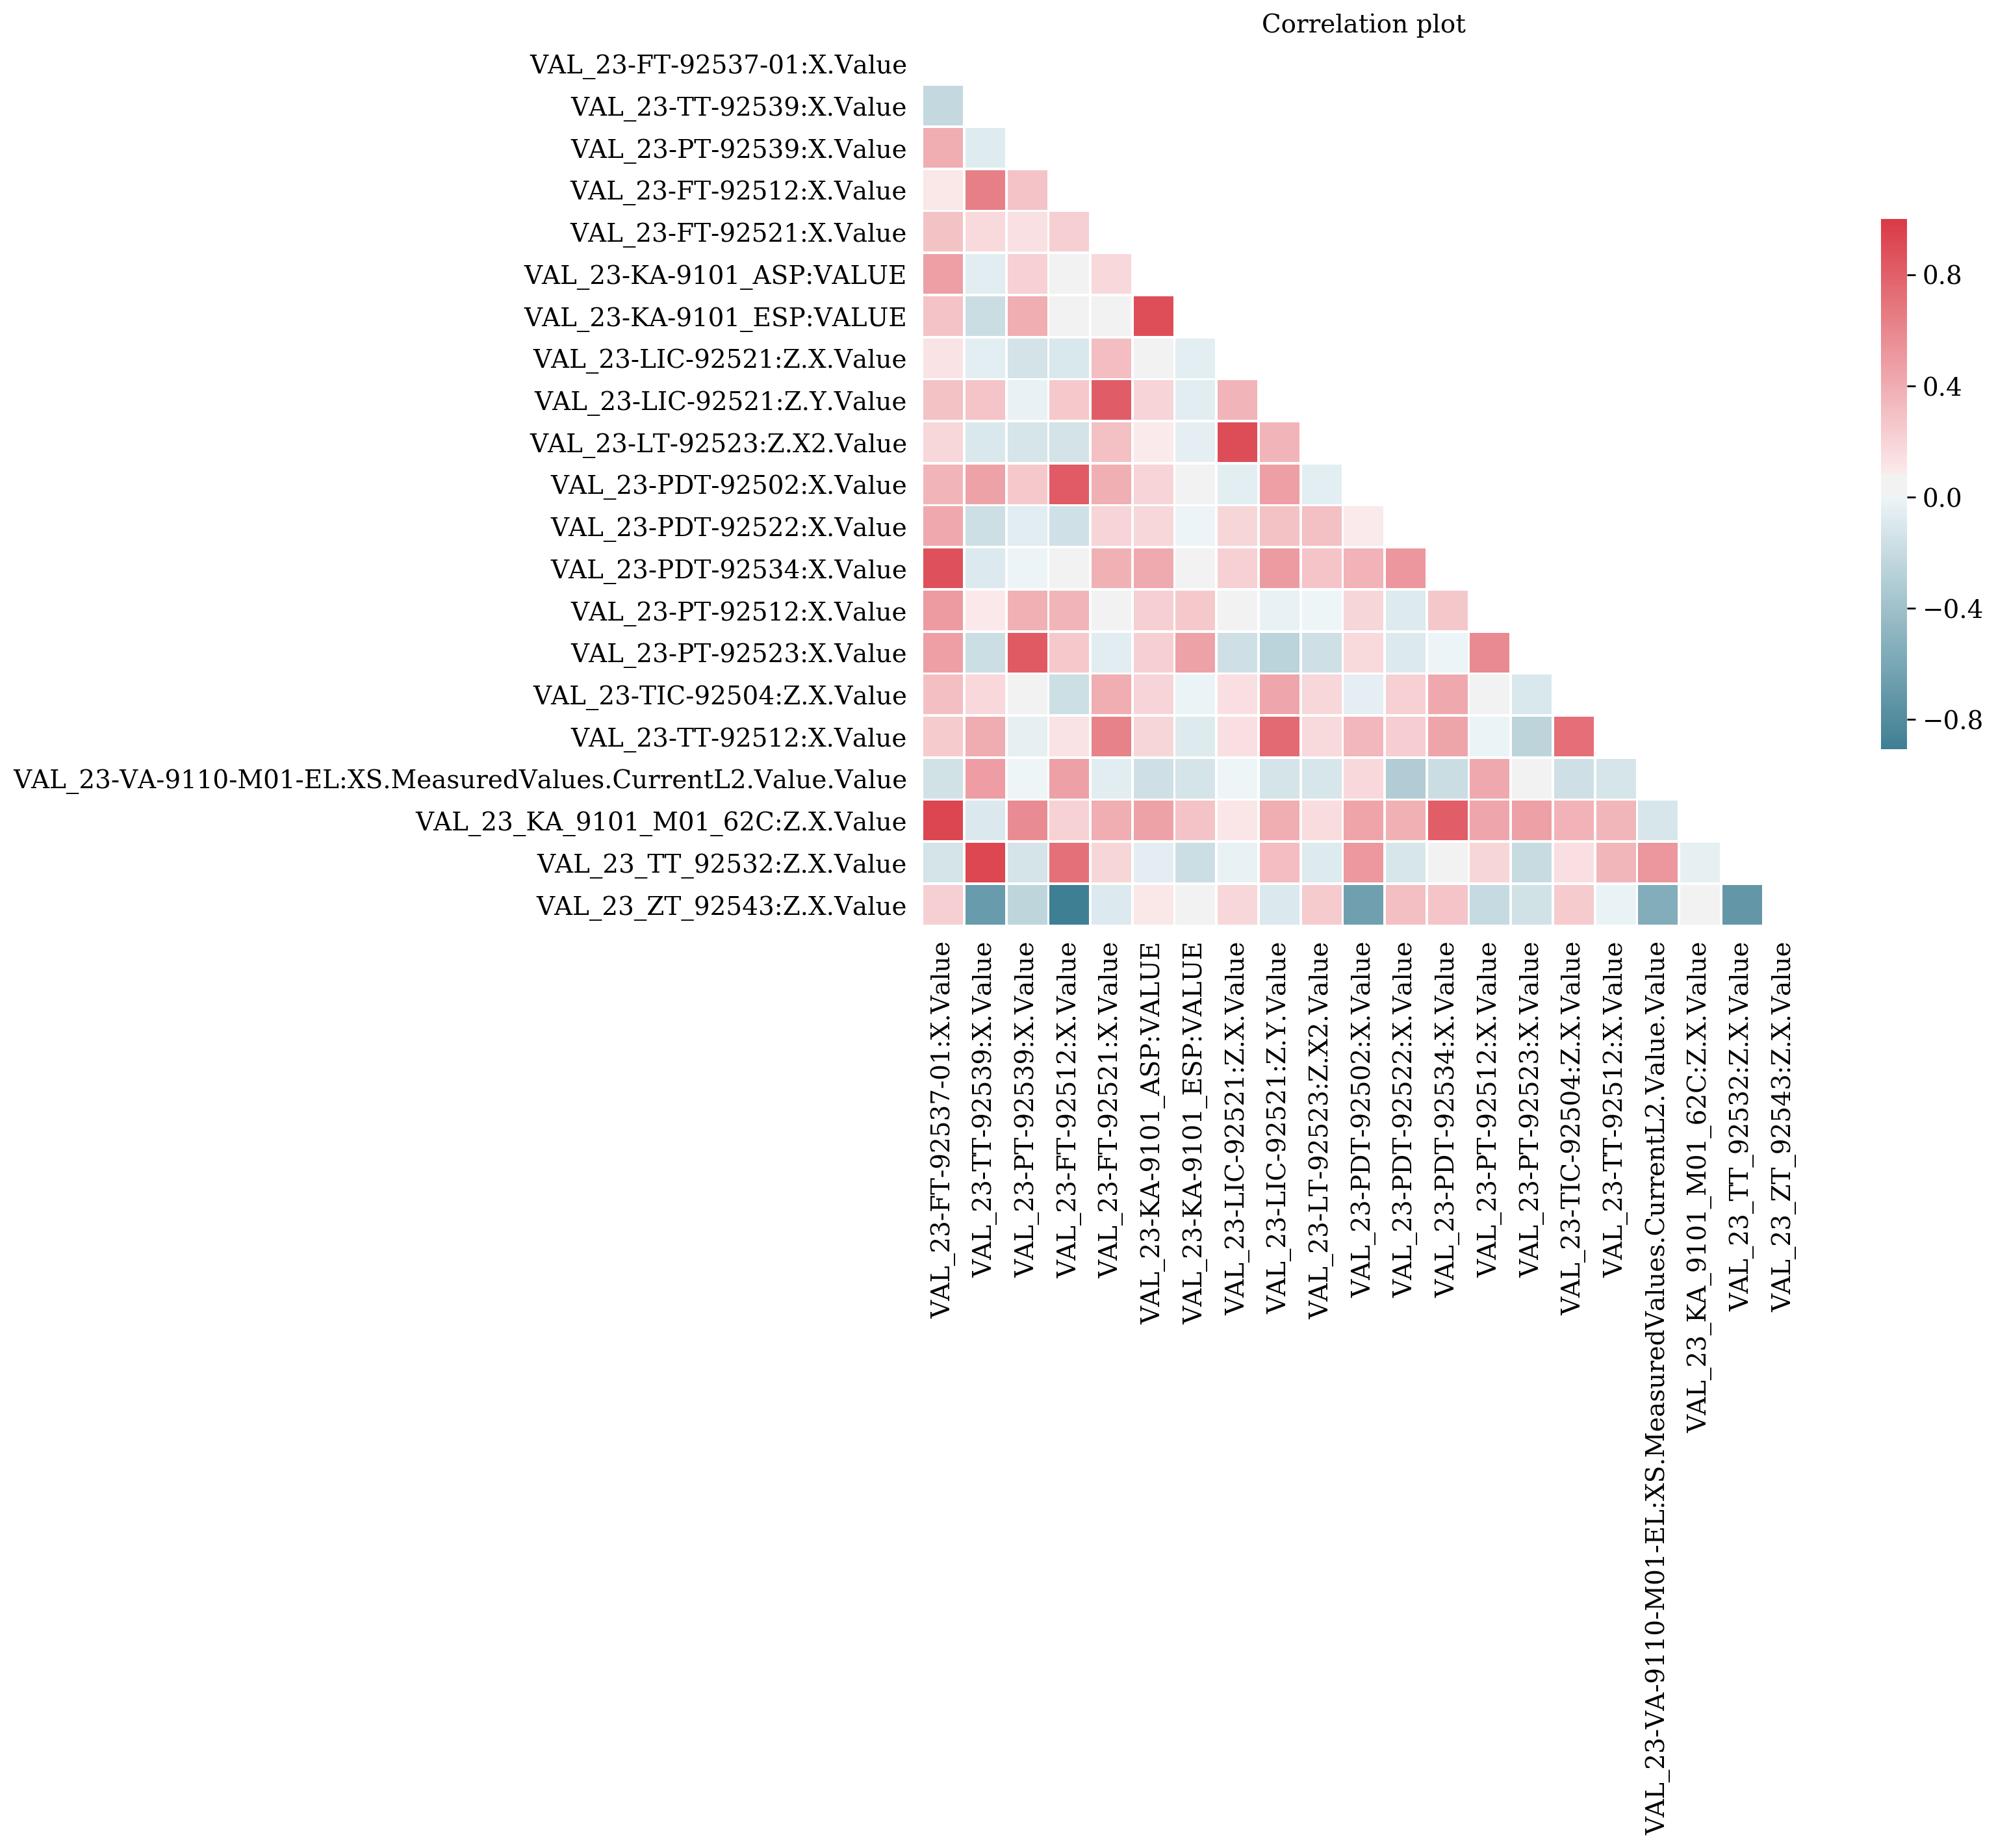

In [24]:
def plot_correlation(df, title="Correlation plot"):
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, linewidths=1, cbar_kws={"shrink": .6})

    ax.set_title(title)
    
    f.show()

def find_correlation(data, threshold=0.95, remove_negative=False):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove.
    Parameters
    -----------
    data : pandas DataFrame
        DataFrame
    threshold : float
        correlation threshold, will remove one of pairs of features with a
        correlation greater than this value.
    remove_negative: Boolean
        If true then features which are highly negatively correlated will
        also be returned for removal.
    Returns
    --------
    select_flat : list
        listof column names to be removed
    """
    corr_mat = data.corr()
    if remove_negative:
        corr_mat = np.abs(corr_mat)
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    for col in corr_mat:
        perfect_corr = corr_mat[col][corr_mat[col] > threshold].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

def remove_correlated_features(data, target_tags=data_targets.columns, threshold=0.95):
    to_drop = find_correlation(data.drop(target_tags, axis=1))
    return data.drop(to_drop, axis=1), to_drop

data_noncorr, dropped_features = remove_correlated_features(data_amelia)
plot_correlation(data_noncorr)

print("\nRemoved {0} features:\n".format(len(dropped_features)))
print(dropped_features)

print("\nThere are {0} features remaining:\n".format(data_noncorr.shape[-1]))
print(list(data_noncorr.columns.values))

#### Feature seleciton by Boruta

We apply the Boruta algorithm in a seperate notebook: ```feature-selection.ipynb```. Using the results there, we find that there are in total six predictors that are highly influential when predicting the flow, temperature and flow. 

In [25]:
selected_features = [
   "VAL_23_ZT_92543:Z.X.Value",
   "VAL_23-PT-92523:X.Value",
   "VAL_23-PDT-92534:X.Value",
   "VAL_23_TT_92532:Z.X.Value",
   "VAL_23-TIC-92504:Z.X.Value",
   "VAL_23_KA_9101_M01_62C:Z.X.Value"
]

all_selected = np.append(data_targets.columns, selected_features)

complete_selected = data_scaled[all_selected]
train_selected = data_train_scaled[all_selected]
valid_selected = data_valid_scaled[all_selected]
test_selected = data_test_scaled[all_selected]

print(complete_selected.shape, train_selected.shape, valid_selected.shape, test_selected.shape)

(88685, 9) (53211, 9) (17737, 9) (17737, 9)


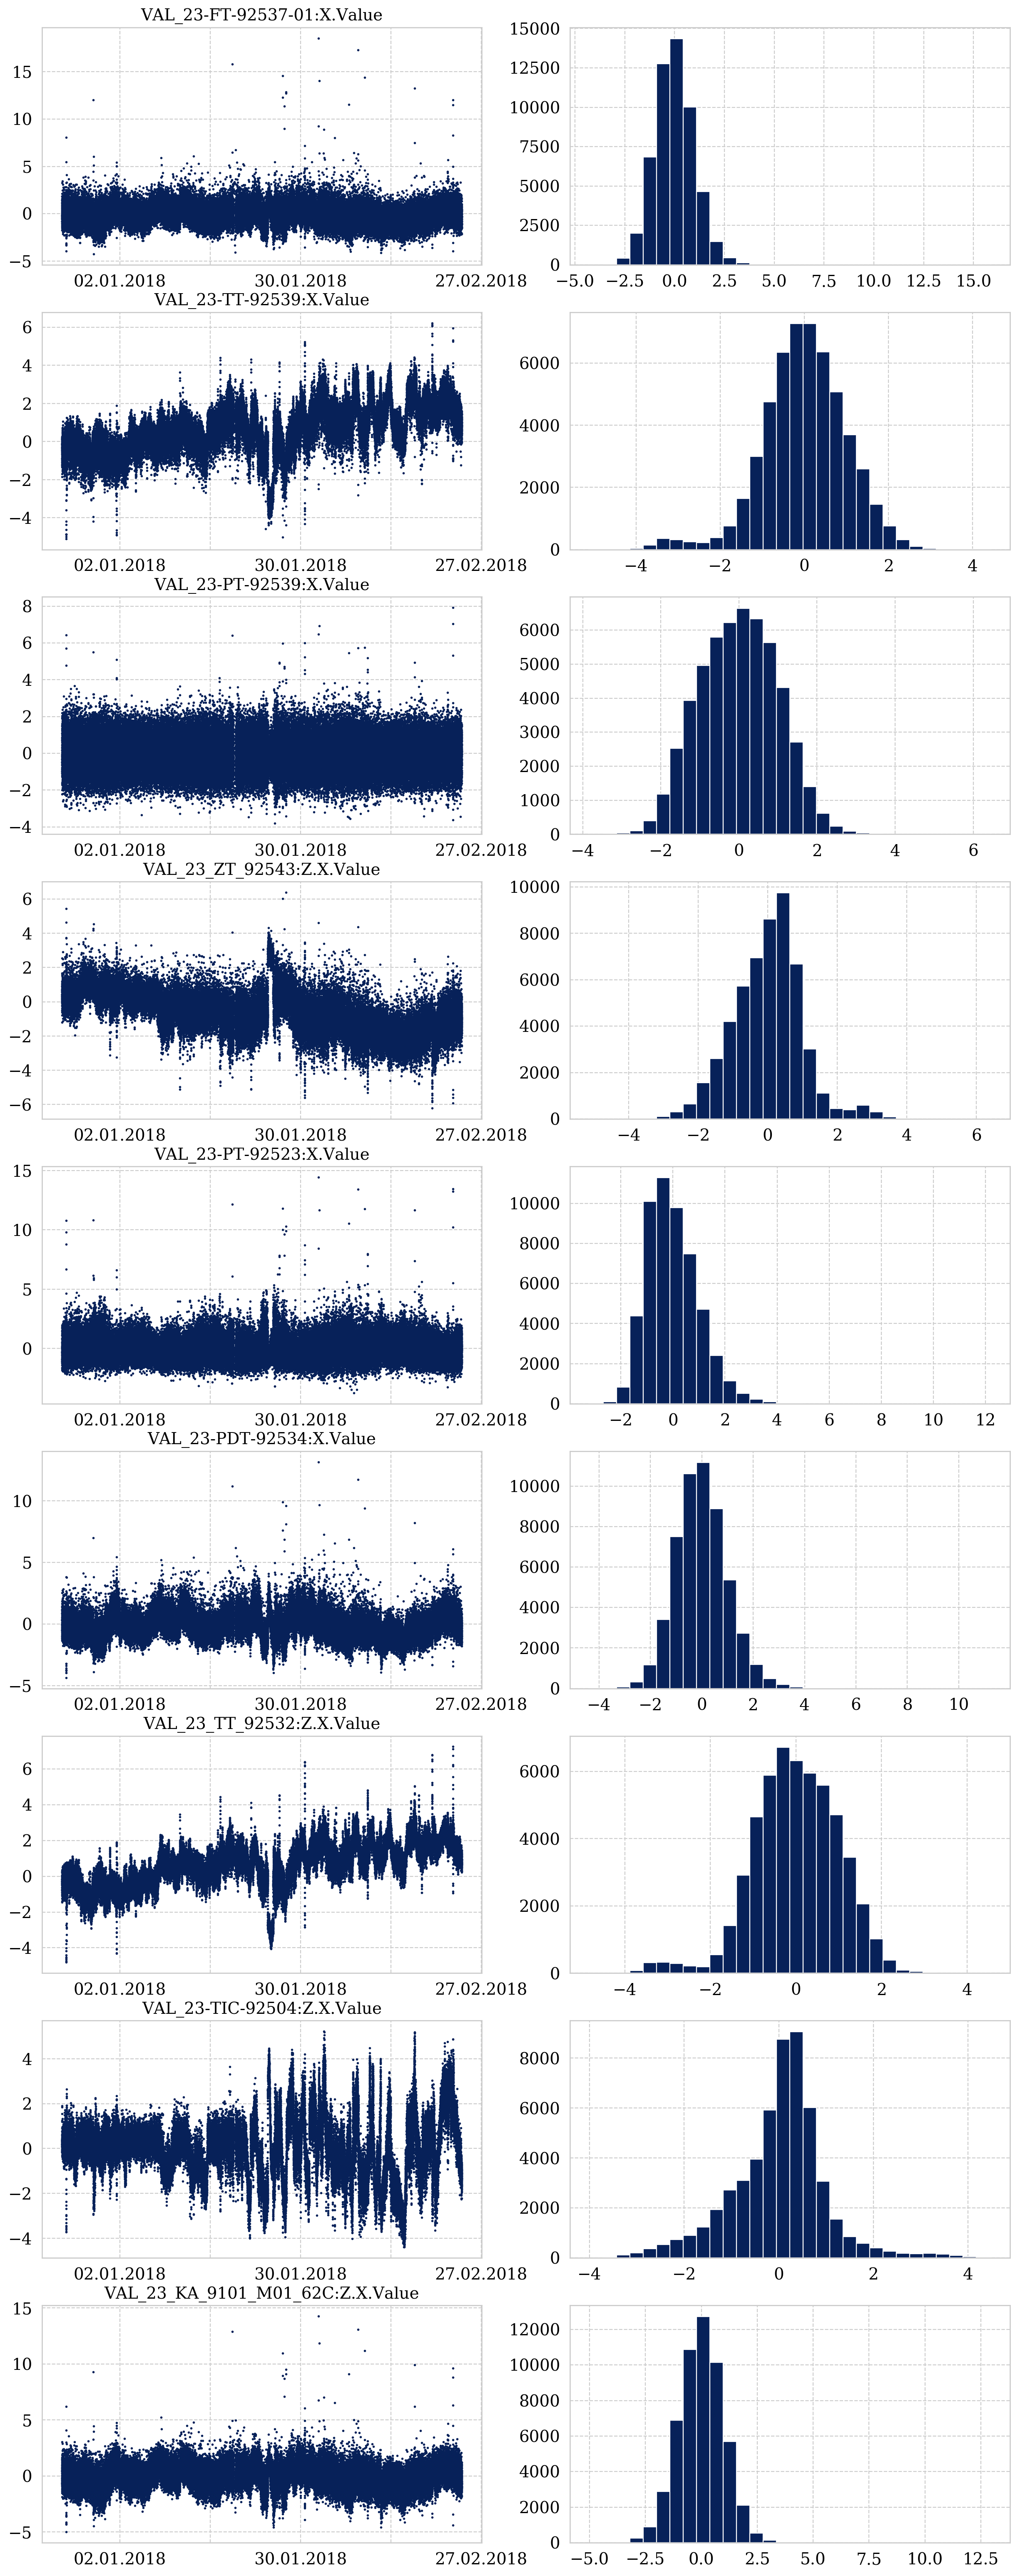

In [26]:
fig, axs = plt.subplots(nrows=int(complete_selected.shape[-1]), ncols=2, figsize=(15,40))
f = 0
for figrow in range(complete_selected.shape[-1]):
    ax1,ax2 = axs[figrow,0], axs[figrow,1]
    
    ax1.plot(complete_selected.iloc[:,f],
            marker="o", markersize=1.0, lw=0)
    ax1.set_title(complete_selected.columns[f])
    
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
    [label.set_visible(False) for label in ax1.get_xticklabels()[1::2]]
    
    ax2.hist(complete_selected.iloc[:train_size,f], bins=30)
    f +=1

fig.show()

---
# (6) Exporting the datasets
<a class="anchor" id="saving"></a>

---

In [27]:
# save scaled dataframes
path = ROOT_PATH + "data/dataframes/"

data_scaled.to_pickle(path+"df_scaled_complete.pkl")
data_train_scaled.to_pickle(path+"df_scaled_train.pkl")
data_valid_scaled.to_pickle(path+"df_scaled_valid.pkl")
data_test_scaled.to_pickle(path+"df_scaled_test.pkl")

complete_selected.to_pickle(path+"df_selected_complete.pkl")
train_selected.to_pickle(path+"df_selected_train.pkl")
valid_selected.to_pickle(path+"df_selected_valid.pkl")
test_selected.to_pickle(path+"df_selected_test.pkl")

print(data_scaled.shape, complete_selected.shape)
print("✓....saved dataframes")


# save data as csv
path = ROOT_PATH + "data/csv/"

data_scaled.to_csv(path + "data_scaled_complete.csv", index=False)
data_train.to_csv(path + "data_scaled_train.csv", index=False)
data_valid.to_csv(path + "data_scaled_valid.csv", index=False)
data_test.to_csv(path + "data_scaled_test.csv", index=False)
print("✓....saved csv's")


# metadata
path = ROOT_PATH + "data/metadata/"

np.save(path + "timestamps/dtimestamps.npy", DTIMESTAMPS)
np.save(path + "timestamps/ts_train.npy", DTIMESTAMPS[:train_size])
np.save(path + "timestamps/ts_valid.npy", DTIMESTAMPS[train_size:-test_size])
np.save(path + "timestamps/ts_test.npy", DTIMESTAMPS[-test_size:])

scaling_stats = pd.DataFrame(np.column_stack((means,stds)), 
                             index=data_scaled.columns, 
                             columns=["Mean", "Std"])

scaling_stats.to_csv(path+"scaling_stats.csv")
scaling_stats.loc[all_selected].to_csv(path+"scaling_stats_selected.csv")
print("✓....saved metadata")

(88685, 32) (88685, 9)
✓....saved dataframes
✓....saved csv's
✓....saved metadata


In [28]:
# make a dummy dataset of a few first observations
num_obs = [5000,10000,25000]
path = ROOT_PATH + "data/dummy/"
for n in num_obs: 
    dum_trainsize = int(0.6 * n)
    dum_validsize = int(0.2 * n)
    dum_testsize = n - (dum_trainsize + dum_validsize)

    dummy_train = train_selected[:dum_trainsize]
    dummy_valid = valid_selected[:dum_validsize]
    dummy_test = test_selected[:dum_testsize]
    dummy_complete = pd.concat([dummy_train, dummy_valid, dummy_test])

    print("Saving dummy files with num obs =",n)
    print(dummy_train.shape, dummy_valid.shape, dummy_test.shape)
    
    dummy_complete.to_pickle(path+"dummy_complete_{0}.pkl".format(n))
    dummy_train.to_pickle(path+"dummy_train_{0}.pkl".format(n))
    dummy_valid.to_pickle(path+"dummy_valid_{0}.pkl".format(n))
    dummy_test.to_pickle(path+"dummy_test_{0}.pkl".format(n))
    print()

Saving dummy files with num obs = 5000
(3000, 9) (1000, 9) (1000, 9)

Saving dummy files with num obs = 10000
(6000, 9) (2000, 9) (2000, 9)

Saving dummy files with num obs = 25000
(15000, 9) (5000, 9) (5000, 9)

